## Imports

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import re

import gensim
from nltk.data import find
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn import metrics

from utils import *

pd.set_option('display.max_rows', 250)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dbadeev_new/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dbadeev_new/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dbadeev_new/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stoplist = stopwords.words('english')
stoplist.append("i'm")

In [3]:
print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Предобработка данных

Данные 'user_id', 'song_id', 'play_count' из файла 'data/train_triplets.txt' -> датафрейм df_echonest.

In [4]:
# df_echonest = pd.read_csv('data/train_triplets.txt', sep='\t', header=None)
# df_echonest.columns = ['user_id', 'song_id', 'play_count']
# df_echonest.head()

In [5]:
# df_echonest.info()

In [6]:
# df_echonest['play_count'].value_counts()

In [7]:
# df_echonest.to_pickle('data/df_echonest.pkl')

Обработка файла с текстами песен. Данные 'track_id', 'mxm_track_id', 'text' из файла 'data/mxm_dataset_train.txt' -> датафрейм df_mxm_text_songs. Из 'text' удаляются стоп-слова

In [8]:
# df_mxm_text_songs = get_mxm_text_songs('data/mxm_dataset_train.txt', stoplist)
# df_mxm_text_songs.head()

In [9]:
# df_mxm_text_songs.to_pickle('data/df_mxm_text_songs.pkl')

Обработка файла с жанрами песен. Данные 'track_id', 'majority_genre','minority_genre' из файла ->
	датафрейм df_tag_genre_songs. Отсутствующие значения заменяются на Nan.

In [10]:
# df_tag_genre_songs = get_tag_genre_songs('data/p02_msd_tagtraum_cd2.cls')
# df_tag_genre_songs.head()

In [11]:
# df_tag_genre_songs.head()

In [12]:
# df_tag_genre_songs.to_pickle('data/df_tag_genre_songs.pkl')

Обработка файла с названиями песен. Данные 'track_id', 'song_id', 'artist','title' из файла -> датафрейм df_tag_artist_title. Отсутствующие значения заменяются на Nan.

In [13]:
# df_tag_artist_title = get_tag_artist_title('data/p02_unique_tracks.txt')
# df_tag_artist_title.head()

Добавляем столбец 'title_pure' с очищенными названиями песен (удалены скобки и содержимое, знаки препинания (кроме апострофа), лишние пробелы. Также названия приведены к нижнему регистру и удалены стоп-слова.

In [14]:
# df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'[\(\[].*?[\)\]]', '', str(x['title'])), axis=1)
#
# df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'[^\'a-zA-Z ]', '', str(x['title'])), axis=1)
#
# df_tag_artist_title['title_pure'] = df_tag_artist_title.apply(lambda x: re.sub(r'\s+', ' ', str(x['title_pure'])), axis=1)
#
# df_tag_artist_title['title_pure'] = df_tag_artist_title['title_pure'].apply(title_without_stopwords, args=[stoplist])
#
# df_tag_artist_title.head(10)

In [15]:
# df_tag_artist_title.to_pickle('data/df_tag_artist_title.pkl')

df_track - дф из df_tag_artist_title с добавленными текстами песен

In [16]:
# df_tag_artist_title = pd.read_pickle('data/df_tag_artist_title.pkl')
# df_mxm_text_songs = pd.read_pickle('data/df_mxm_text_songs.pkl')
# df_track = pd.merge(df_tag_artist_title, df_mxm_text_songs, on='track_id', how='outer')
# df_track.head()

Добавляем в df_track столбцы по значимым жанрам

In [17]:
# df_tag_genre_songs = pd.read_pickle('data/df_tag_genre_songs.pkl')
# df_track = pd.merge(df_track, df_tag_genre_songs, on='track_id', how='outer')
# df_track.info()

Заменяем Nan в столбце 'title_pure' на пустую строку

In [18]:
# df_track.isnull().sum()

In [19]:
# df_track[['title_pure']] = df_track[['title_pure']].fillna('')

In [20]:
# df_track.to_pickle('data/df_track.pkl')

## Top-250 tracks


		1. датафрейм со след. полями:
			1. номер индекса
			2. имя исполнителя
			3. название трека
			4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.

По заданию нам нужны 250 записей

In [21]:
df_echonest = pd.read_pickle('data/df_echonest.pkl')
df_1 = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False)[:250].reset_index()
df_1.head()

,song_id,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


Добавляем столбцы из df_track

In [22]:
df_track = pd.read_pickle('data/df_track.pkl')
df_1 = pd.merge(df_1, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='inner')
df_1.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN


Оставляем требуемые по заданию столбцы

In [23]:
df_1 = df_1[['artist', 'title', 'play_count']]
df_1.head()

,artist,title,play_count
0,Dwight Yoakam,You're The One,726885
1,Björk,Undo,648239
2,Kings Of Leon,Revelry,527893
3,Harmonia,Sehr kosmisch,425463
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,389880


In [24]:
df_1.tail()

,artist,title,play_count
245,Triple Six Mafia,Now I'm High_ Really High,35253
246,The Red Jumpsuit Apparatus,Face Down (Album Version),35245
247,Linkin Park,New Divide (Album Version),35191
248,Selena Gomez & The Scene,Naturally,35074
249,Creedence Clearwater Revival,Have You Ever Seen The Rain,34831


## Top-100 tracks

		1. для заданного жанра на выходе датафрейм со след. полями:
			1. номер индекса
			2. имя исполнителя
			3. название трека
			4. количество воспроизведений
		2.  Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3.  Использовать только основной жанр для выполнения подзадачи.

Сначала считываем дф с количеством воспроизведений

In [25]:
df_2 = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False).reset_index()
df_2.head()

,song_id,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


Добавляем столбцы из df_track

In [26]:
df_2 = pd.merge(df_2, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='left')
df_2.head()

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre
0,SOBONKR12A58A7A7E0,726885,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,one,1104550,love love know oh oh oh oh oh oh oh oh oh one ...,Country,NaN
1,SOAUWYT12A81C206F1,648239,TRGXQES128F42BA5EB,Björk,Undo,undo,1879235,oh oh oh oh way give tri tri tri cri hard hard...,Rock,Electronic
2,SOSXLTC12AF72A7F54,527893,TRONYHY128F92C9D11,Kings Of Leon,Revelry,revelry,NaN,NaN,Rock,NaN
3,SOFRQTD12A81C233C0,425463,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,sehr kosmisch,NaN,NaN,Rock,Metal
4,SOEGIYH12A6D4FC0E3,389880,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,horn concerto e flat k ii romance andante cant...,NaN,NaN,NaN,NaN


Формируем словарь по жанрам

In [27]:
df_2_dict = {'Rock': df_2[df_2['majority_genre'] == 'Rock'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Rap': df_2[df_2['majority_genre'] == 'Rap'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Jazz': df_2[df_2['majority_genre'] == 'Jazz'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Electronic': df_2[df_2['majority_genre'] == 'Electronic'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Pop': df_2[df_2['majority_genre'] == 'Pop'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Blues': df_2[df_2['majority_genre'] == 'Blues'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Country': df_2[df_2['majority_genre'] == 'Country'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'Reggae': df_2[df_2['majority_genre'] == 'Reggae'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']],
			  'New Age': df_2[df_2['majority_genre'] == 'New Age'][:100].reset_index().drop(['index'], axis=1)[['artist', 'title', 'play_count']]}

Rock - первые и последние записи из 100

In [28]:
df_2_dict['Rock'].head()

,artist,title,play_count
0,Björk,Undo,648239
1,Kings Of Leon,Revelry,527893
2,Harmonia,Sehr kosmisch,425463
3,OneRepublic,Secrets,292642
4,Tub Ring,Invalid,268353


In [29]:
df_2_dict['Rock'].tail()

,artist,title,play_count
95,Metric,Gold Guns Girls,28148
96,Pearl Jam,Encore Break,27579
97,Daughtry,No Surprise,27187
98,Eric Clapton,Tears In Heaven,26999
99,Nick Lowe,All Men Are Liars,26683


Rap - первые и последние записи из 100

In [30]:
df_2_dict['Rap'].head()

,artist,title,play_count
0,Alliance Ethnik,Représente,241669
1,Beastie Boys,The Maestro,72381
2,Eminem,Without Me,63918
3,Black Eyed Peas,Imma Be,62438
4,Kid Cudi,Up Up & Away,59810


In [31]:
df_2_dict['Rap'].tail()

,artist,title,play_count
95,Shwayze,Buzzin',7384
96,Orishas,El Kilo,7324
97,Snoop Dogg,Sexual Eruption,7171
98,Bone Thugs-N-Harmony,Tha Crossroads,7124
99,Orishas,Habana,6998


Electronic - первые и последние записи из 100

In [32]:
df_2_dict['Electronic'].head()

,artist,title,play_count
0,Southside Spinners,Luvstruck,84225
1,The Black Keys,Tighten Up,81179
2,Deadmau5,Ghosts 'n' Stuff (Original Instrumental Mix),63951
3,Daft Punk,Harder Better Faster Stronger,63170
4,Clara Hill,Clara meets Slope - Hard To Say,58887


In [33]:
df_2_dict['Electronic'].tail()

,artist,title,play_count
95,Nicolette,No Government,9541
96,Two Door Cinema Club,Eat That Up_ It's Good For You,9524
97,Moby,Why Does My Heart Feel So Bad? (2006 Digital R...,9491
98,Death In Vegas,Girls,9490
99,Johan Gielen,Flash,9431


## Collections

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:
			1. baseline
				1. ищутся ключевое слово и количество его вхождений в песне
				2. найденное фильтруется с помощью некоторого порога
				3. происходит сортировка по количеству воспроизведений
			2. word2vec
				1. помимо ключевого слова, происходит поиск для нескольких найденных похожих токенов
			3. classification
				1. разметить часть данных
				2. для тестовой части на основе алгоритмов классификации, предсказать,  принадлежит ли трек к определенному классу.

Сформируем датасет с необходимыми данными, отсортировав его по количеству воспроизведений

In [34]:
# df_collections = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False).reset_index()
# df_collections.head()

Добавляем столбцы из df_track

In [35]:
# df_collections = pd.merge(df_collections, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='left')
# df_collections.head()

Если текст песни 'text' и преобразованное название 'title_pure' отсутствуют, прописываем пустое значение в строке соответствующего столбца

In [36]:
# df_collections[['text']] = df_collections[['text']].fillna('')
# df_collections[['title_pure']] = df_collections[['title_pure']].fillna('')
# df_collections = df_collections.astype({'text': str})
# df_collections.isnull().sum()

Добавляем новый столбец с объединенным предобработанным названием и текстом

In [37]:
# df_collections['title_and_text'] = df_collections['title_pure'] + ' ' + df_collections['text']
# df_collections.head(50)

Стемминг строк столбца 'title_and_text'

In [38]:
# df_collections['title_and_text'] = df_collections.apply(lambda x: stemline(str(x['title_and_text'])), axis=1)
# df_collections.head(50)

BASELINE

	   1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:
			1. baseline
				1. ищутся ключевое слово и количество его вхождений в песне
				2. найденное фильтруется с помощью некоторого порога
				3. происходит сортировка по количеству воспроизведений

Стемминг категорий для совпадения с текстовыми значениями 'title_and_text' датафрейма

In [39]:
categories = ['love', 'war', 'money', 'happiness', 'loneliness']
categories_stem = stemline(' '.join(categories)).split()
categories_stem

['love', 'war', 'money', 'happi', 'loneli']

Добавляем столбцы в датафрейм для каждой категории. Значение - количество полных совпадений в строке столбца 'title_and_text'

In [40]:
# df_collections['love'] = df_collections.apply(lambda x: str(x['title_and_text']).count('love'), axis=1)
# df_collections['war'] = df_collections.apply(lambda x: str(x['title_and_text']).count('war'), axis=1)
# df_collections['money'] = df_collections.apply(lambda x: str(x['title_and_text']).count('money'), axis=1)
# df_collections['happiness'] = df_collections.apply(lambda x: str(x['title_and_text']).count('happi'), axis=1)
# df_collections['loneliness'] = df_collections.apply(lambda x: str(x['title_and_text']).count('loneli'), axis=1)
# df_collections.info()

In [41]:
# df_collections.head(50)

In [42]:
# df_collections.to_pickle('data/df_collections.pkl')

In [43]:
df_collections = pd.read_pickle('data/df_collections.pkl')

In [44]:
collections_baseline_('love', 40)

,artist,title,play_count
0,The B-52's,Love Shack,20226
1,Transvision Vamp,I Want Your Love,19988
2,Twista,Sunshine (Feat. Anthony Hamilton) (Edited Albu...,10992
3,Wilson Pickett,I'm In Love (Single/LP Version),9713
4,Beyoncé,Dangerously In Love,8336
5,Tears For Fears,Sowing The Seeds Of Love,6996
6,Jill Scott,It's Love,2648
7,Lady Sovereign,Love Me Or Hate Me,2296
8,Ashford & Simpson,Found A Cure,2141
9,Beyonce,Keep Giving Your Love To Me (Beyonce) (Amended...,1980


In [45]:
collections_baseline_('war', 10)

,artist,title,play_count
0,Guns N' Roses,Civil War,22893
1,Kanye West,The Glory,3934
2,Cobra Starship,The City Is At War (Album Version),3480
3,Operation Ivy,Take Warning,3041
4,Iration,Love/Hate,2370
5,Coldplay,Twisted Logic,2364
6,Buju Banton,African Pride,2326
7,Yeah Yeah Yeahs,Warrior,1854
8,The 2 Live Crew,Me So Horny,1818
9,Rage Against The Machine,Township Rebellion,1644


In [46]:
collections_baseline_('happiness', 5)

,artist,title,play_count
0,Avril Lavigne,My Happy Ending,27203
1,Nirvana,Dumb,13167
2,Gorillaz,Clint Eastwood (Explicit),12697
3,Gorillaz,Clint Eastwood (Ed Case/Sweetie Irie Refix) (E...,12104
4,The Verve,Lucky Man,10150
5,Infected Mushroom,Deeply Disturbed,7212
6,Powderfinger,My Happiness,7202
7,Skunk Anansie,Hedonism - Just Because You Feel Good,6605
8,Kylie Minogue,Drunk,5493
9,Neutral Milk Hotel,Three Peaches,5204


In [47]:
collections_baseline_('something')

Sorry, no such word something in song's categories. Try another one.


""


WORD2VEC

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:

			2. word2vec
				1. помимо ключевого слова, происходит поиск для нескольких найденных похожих токенов

Будем искать синонимы среди 44К слов, используя модель из https://www.nltk.org/howto/gensim.html

In [48]:
## for stemming
# ps = PorterStemmer()
# nltk.download('word2vec_sample')
#
# word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
# model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)


In [49]:
# words = ['love', 'war', 'happiness', 'loneliness', 'money']
#
# synonyms = {}
# for word in words:
# 	top_syn = model.most_similar(positive=word, topn = 10)
# 	top_syn_stem = set(map(lambda x: ps.stem(x[0]), top_syn))
# 	synonyms[word] = list(top_syn_stem)
#
# print(synonyms)

Добавляем столбцы в датафрейм для каждой категории. Значение - общее количество полных совпадений в строке столбца ‘title_and_text’ с синонимами категорий.

In [50]:
# df_collections['love_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['love']])
# df_collections['war_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['war']])
# df_collections['happiness_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['happiness']])
# df_collections['loneliness_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['loneliness']])
# df_collections['money_syn'] = df_collections['title_and_text'].apply(count_coinc, args=[synonyms['money']])
# df_collections.info()

In [51]:
# df_collections.head(30)

In [52]:
# df_collections.to_pickle('data/df_collections_syn.pkl')

In [53]:
df_collections_syn = pd.read_pickle('data/df_collections_syn.pkl')

In [54]:
collections_baseline_('love', 40, 'y')

,artist,title,play_count
0,The B-52's,Love Shack,20226
1,Transvision Vamp,I Want Your Love,19988
2,Twista,Sunshine (Feat. Anthony Hamilton) (Edited Albu...,10992
3,Wilson Pickett,I'm In Love (Single/LP Version),9713
4,Beyoncé,Dangerously In Love,8336
5,Tears For Fears,Sowing The Seeds Of Love,6996
6,Jill Scott,It's Love,2648
7,Lady Sovereign,Love Me Or Hate Me,2296
8,Ashford & Simpson,Found A Cure,2141
9,Beyonce,Keep Giving Your Love To Me (Beyonce) (Amended...,1980


In [55]:
collections_baseline_('war', 10, 'y')

,artist,title,play_count
0,Guns N' Roses,Civil War,22893
1,Kanye West,The Glory,3934
2,Cobra Starship,The City Is At War (Album Version),3480
3,Operation Ivy,Take Warning,3041
4,Iration,Love/Hate,2370
5,Coldplay,Twisted Logic,2364
6,Buju Banton,African Pride,2326
7,Yeah Yeah Yeahs,Warrior,1854
8,The 2 Live Crew,Me So Horny,1818
9,Rage Against The Machine,Township Rebellion,1644


In [56]:
collections_baseline_('happiness', 5, 'y')

,artist,title,play_count
0,Two Door Cinema Club,What You Know,49030
1,Avril Lavigne,My Happy Ending,27203
2,Snow Patrol,Hands Open,19813
3,Outkast Featuring Killer Mike,The Whole World,16240
4,Terrorvision,Glad All Over,13905
5,Snow Patrol,You Could Be Happy,13616
6,Nirvana,Dumb,13167
7,Gorillaz,Clint Eastwood (Explicit),12697
8,Gorillaz,Clint Eastwood (Ed Case/Sweetie Irie Refix) (E...,12104
9,Muse,Bliss,11209


CLASSIFICATION

		1. по заданному ключевому слову (love, war, happiness) на выходе датафрейм (50 строк) со след. полями:
				1. номер индекса
				2. имя исполнителя
				3. название трека
				4. количество воспроизведений
		2. Таблица должна быть отсортирована по количеству воспроизведений по убыванию.
		3. Нужно использовать следующие рекомендации:

			3. classification
				1. разметить часть данных
				2. для тестовой части на основе алгоритмов классификации, предсказать,  принадлежит ли трек к определенному классу.

In [57]:
# class_dict = {'love_syn': 0, 'war_syn': 1, 'happiness_syn': 2, 'loneliness_syn': 3, 'money_syn': 4}

Разметку будем делать на основании значений столбцов 'love_syn', 'war_syn', 'happiness_syn', 'loneliness_syn', 'money_syn'

In [58]:
# df_collections_syn = pd.read_pickle('data/df_collections_syn.pkl')
#
# df_5 = df_collections_syn[['love_syn', 'war_syn', 'happiness_syn', 'loneliness_syn', 'money_syn']]
# df_5.columns = ['0', '1', '2', '3', '4']
# df_5.head(20)

Посчитаем, для каждой песни какой класс дал максимальное значение

In [59]:
# class_ = df_5.idxmax(axis=1)
# val = df_5.max(axis=1)

In [60]:
# class_df = class_.to_frame(name='class')
# val_df = val.to_frame(name='value')
# df_5 = pd.concat([df_5, class_df, val_df], axis=1)
# df_5.head()

Если максимальное число ('value') меньше 2, то помечаем, что такие песни не принадлежат ни одному классу

In [61]:
# df_5.loc[df_5['value'] < 2, 'class'] = -1
# df_5.head()

Добавляем столбец классов 'class' из df_5 в  датасет df_collections_syn

In [62]:
# df_collections_syn = pd.concat([df_collections_syn, df_5['class']], axis=1)
# df_collections_syn.head()

Также добавляем столбец значений 'value' из df_5 в  датасет df_collections_syn

In [63]:
# df_collections_syn = pd.concat([df_collections_syn, df_5['value']], axis=1)
# df_collections_syn.head()

In [64]:
# df_collections_syn = df_collections_syn.astype({'class': np.int8})
# df_collections_syn.info()

In [65]:
# df_collections_syn.to_pickle('data/df_collections_syn_class_val.pkl')

Выделяем в df_has_class размеченные песни

In [66]:
df_collections_syn = pd.read_pickle('data/df_collections_syn_class_val.pkl')
df_has_class = df_collections_syn.loc[df_collections_syn['class'] >= 0]
df_has_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44505 entries, 0 to 384527
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         44505 non-null  object
 1   play_count      44505 non-null  int64 
 2   track_id        44505 non-null  object
 3   artist          44505 non-null  object
 4   title           44505 non-null  object
 5   title_pure      44505 non-null  object
 6   mxm_track_id    44076 non-null  object
 7   text            44505 non-null  object
 8   majority_genre  27912 non-null  object
 9   minority_genre  8151 non-null   object
 10  title_and_text  44505 non-null  object
 11  love            44505 non-null  int64 
 12  war             44505 non-null  int64 
 13  money           44505 non-null  int64 
 14  happiness       44505 non-null  int64 
 15  loneliness      44505 non-null  int64 
 16  love_syn        44505 non-null  int64 
 17  war_syn         44505 non-null  int64 
 18  happi

In [67]:
# df_has_class.to_pickle('data/df_has_class.pkl')

In [68]:
df_has_class = pd.read_pickle('data/df_has_class.pkl')

Выберем для построения модели по 1000 песен из каждой из 5 категорий датафрейма df_model

In [69]:
df_love = df_has_class[df_has_class['class'] == 0][:1000]
df_war = df_has_class[df_has_class['class'] == 1][:1000]
df_happiness = df_has_class[df_has_class['class'] == 2][:1000]
df_loneliness = df_has_class[df_has_class['class'] == 3][:1000]
df_money = df_has_class[df_has_class['class'] == 4][:1000]
df_model = pd.concat([df_love, df_war, df_happiness, df_loneliness, df_money], axis=0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 80705
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         5000 non-null   object
 1   play_count      5000 non-null   int64 
 2   track_id        5000 non-null   object
 3   artist          5000 non-null   object
 4   title           5000 non-null   object
 5   title_pure      5000 non-null   object
 6   mxm_track_id    4969 non-null   object
 7   text            5000 non-null   object
 8   majority_genre  3680 non-null   object
 9   minority_genre  905 non-null    object
 10  title_and_text  5000 non-null   object
 11  love            5000 non-null   int64 
 12  war             5000 non-null   int64 
 13  money           5000 non-null   int64 
 14  happiness       5000 non-null   int64 
 15  loneliness      5000 non-null   int64 
 16  love_syn        5000 non-null   int64 
 17  war_syn         5000 non-null   int64 
 18  happine

Для оценки релевантности предсказаний модели, выделим из датасета df_collections_syn 50 песен, у которых на основании предыдущего анализа частотности слов ни одна из 5 заданных категорий не оказалась выраженной. Будем рассматривать песни, у которых ‘title_and_text’ содержит более 20 слов

In [70]:
df_unclassed = df_collections_syn.loc[((df_collections_syn['class'] == -1) & (df_collections_syn['title_and_text'].str.count(' ') > 20))][:50]
df_unclassed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 6 to 242
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         50 non-null     object
 1   play_count      50 non-null     int64 
 2   track_id        50 non-null     object
 3   artist          50 non-null     object
 4   title           50 non-null     object
 5   title_pure      50 non-null     object
 6   mxm_track_id    50 non-null     object
 7   text            50 non-null     object
 8   majority_genre  29 non-null     object
 9   minority_genre  8 non-null      object
 10  title_and_text  50 non-null     object
 11  love            50 non-null     int64 
 12  war             50 non-null     int64 
 13  money           50 non-null     int64 
 14  happiness       50 non-null     int64 
 15  loneliness      50 non-null     int64 
 16  love_syn        50 non-null     int64 
 17  war_syn         50 non-null     int64 
 18  happiness_s

In [71]:
df_unclassed.head(50)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn,class,value
6,SONYKOW12AB01849C9,292642,TROAQBZ128F9326213,OneRepublic,Secrets,secrets,9076039,like like time time time time come get get see...,Rock,NaN,...,0,0,0,0,0,0,0,0,-1,0
7,SOPUCYA12A8C13A694,274627,TRFQOSP128F427C2B2,Five Iron Frenzy,Canada,canada,2320738,like come go go go go go oh oh oh oh oh get go...,NaN,NaN,...,0,0,0,0,0,0,0,0,-1,0
13,SODJWHY12A8C142CCE,209212,TRVCUSW128F92F20C6,Train,Hey_ Soul Sister,hey soul sister,9574863,love know know know like like time one one one...,NaN,NaN,...,0,0,0,1,0,1,0,0,-1,1
15,SOTCMDJ12A6D4F8528,192884,TRZJNDO128EF343498,Angels and Airwaves,The Gift,gift,5024252,know know know know know know know like like l...,NaN,NaN,...,0,0,0,0,0,1,1,0,-1,1
23,SORJICW12A8C13640D,130116,TRVAWVL128F93508F9,Pavement,Mercy:The Laundromat,mercythe laundromat,1070269,back eye long wait wait wait home insid line l...,NaN,NaN,...,0,0,0,1,0,0,0,0,-1,1
31,SONQCXC12A6D4F6A37,115134,TRJWVCU128F14581FF,Sheena Easton,Strut (1993 Digital Remaster),strut digital remaster,5887849,like like like like like come come come come c...,NaN,NaN,...,0,0,0,0,1,0,0,0,-1,1
32,SOCVTLJ12A6310F0FD,114362,TRENTGL128E0780C8E,Coldplay,Clocks,clocks,1604099,know come come come go go go go go oh oh never...,Rock,NaN,...,0,0,0,0,0,0,0,0,-1,0
38,SOLRGVL12A8C143BC3,110240,TRRUVLO128F92DE6F7,La Roux,Bulletproof,bulletproof,9562333,love time time time time time time time time t...,Pop,Electronic,...,0,0,0,1,0,0,0,0,-1,1
46,SOXLOQG12AF72A2D55,99137,TRWBSCZ128F932F2F9,Beastie Boys,Unite (2009 Digital Remaster),unite digital remaster,5632363,know know know know like like like like like t...,NaN,NaN,...,1,0,0,0,0,1,0,1,-1,1
48,SOSJRJP12A6D4F826F,98667,TRJRDDL128F147CBE8,Metallica,Master Of Puppets,master puppets,5360064,come come come see see see see see see never w...,Metal,NaN,...,0,0,0,1,0,0,0,0,-1,1


Добавим элементы df_unclassed в df_model, чтобы для всех текстов построить эмбеддинги нужной размерности

In [72]:
df_model_plus = pd.concat([df_model, df_unclassed], axis=0)
df_model_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 0 to 242
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         5050 non-null   object
 1   play_count      5050 non-null   int64 
 2   track_id        5050 non-null   object
 3   artist          5050 non-null   object
 4   title           5050 non-null   object
 5   title_pure      5050 non-null   object
 6   mxm_track_id    5019 non-null   object
 7   text            5050 non-null   object
 8   majority_genre  3709 non-null   object
 9   minority_genre  913 non-null    object
 10  title_and_text  5050 non-null   object
 11  love            5050 non-null   int64 
 12  war             5050 non-null   int64 
 13  money           5050 non-null   int64 
 14  happiness       5050 non-null   int64 
 15  loneliness      5050 non-null   int64 
 16  love_syn        5050 non-null   int64 
 17  war_syn         5050 non-null   int64 
 18  happiness

In [73]:
df_model_plus.tail(60)

,song_id,play_count,track_id,artist,title,title_pure,mxm_track_id,text,majority_genre,minority_genre,...,money,happiness,loneliness,love_syn,war_syn,happiness_syn,loneliness_syn,money_syn,class,value
79966,SOOJOBN12A8C135AC4,184,TRIGVNU128F92D95C8,Lil Wayne_ DJ Drama,I'm The Best Rapper Alive,best rapper alive,5576006,like like like one see got got got got got got...,NaN,NaN,...,2,0,0,0,0,0,0,3,4,3
80007,SOTIMOW12A58A7718E,183,TRPWDYA128F92D5286,Green River Ordinance,Goodbye L.A.,goodbye la,8696628,time time time oh oh oh oh la la la la la la l...,Rock,NaN,...,0,0,0,0,0,0,0,3,4,3
80253,SOJVNTP12A6D4FBECD,182,TRWXWLI128F14A4226,Diana Krall,Do It Again,,683957,know know know like time time time time time t...,Jazz,NaN,...,3,0,0,1,0,0,0,3,4,3
80383,SOTEAPD12A67AE0A63,182,TRIREDM128EF343309,Under The Influence Of Giants,Got Nothing,got nothing,5437273,come oh oh oh oh oh oh oh oh oh oh got got got...,Rock,Pop,...,2,0,0,0,0,0,0,2,4,2
80402,SOLOUHP12A6D4F797E,182,TREBIFO128F1483C62,The Matches,Papercut Skin,papercut skin,6146146,time time time time come come go la make day d...,Rock,NaN,...,0,0,0,0,0,0,0,10,4,10
80545,SOZINST12A8C138432,181,TRIXLBD128F428A085,U.S.D.A.,Throw This Money,throw money,6189414,know know know like like like like come go go ...,Rap,NaN,...,11,0,0,0,0,4,0,12,4,12
80610,SOOJRJH12AC4689784,181,TRMDVZU12903CF5E3E,Adema,Enter The Cage,enter cage,3317034,time one one one one one one one get get get g...,Rock,NaN,...,0,0,0,0,1,0,0,3,4,3
80621,SOGTXTA12AB018651B,181,TRWZRYO128F9330ADF,Tankard,Rockstars No. 1,rockstars,9476867,know know know like like like time time time t...,Metal,NaN,...,2,0,0,0,0,0,0,2,4,2
80696,SOTICOT12A6D4F5AE7,181,TRMEMKB128F14804A8,The Panic Channel,Night One (From Planchette),night one planchette,5411505,know know time come go go oh want want want ma...,NaN,NaN,...,8,0,0,0,0,0,0,8,4,8
80705,SOVZDBH12A6D4F9374,181,TRLXBJP128F1491F32,Matt Pond PA,Summer (Butcher Two) (LP Version),summer butcher two lp version,2345303,like one see see see make away back night nigh...,NaN,NaN,...,0,0,0,0,0,0,0,3,4,3


Преобразуем тексты песен в эмбеддинги с помощью TfidfVectorizer:
sublinear_df = True, чтобы использовать логарифмическую форму для частоты слов;
min_df — минимальное количество текстов, в которых должно присутствовать слово;
ngram_range = (1, 2), т.е. учитываются как униграммы, так и биграммы.

In [74]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features_all = tfidf.fit_transform(df_model_plus['title_and_text']).toarray()
labels = df_model['class']
features_all.shape

(5050, 16994)

Выделим первые 5000 эмбеддингов текстов с известными категориями для построения модели и последние 50 с неопределенными категориями для дальнейшей разметки, когда модель будет готова

In [75]:
features = features_all[:5000]
features_unclassed = features_all[5000:]
features.shape

(5000, 16994)

5000 текстов для построения модели представлены фичами из различных униграмм и биграмм от всех 5050 текстов.

Для построения предсказаний будем обучать модель Linear Support Vector Machine (https://habr.com/ru/company/ods/blog/484148/)

In [76]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_model.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

По результатам построим confusion matrix (матрица несоответствия) между предсказанными и фактическими метками

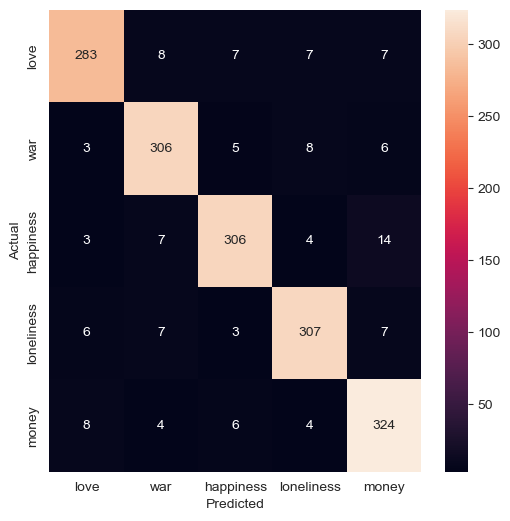

In [77]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['love', 'war', 'happiness', 'loneliness', 'money'], yticklabels=['love', 'war', 'happiness', 'loneliness', 'money'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

plt.show()
Проверим производительность модели по полному набору данных, разбив весь датасет на (train, test) 10 различными способами (https://stephenallwright.com/cross_val_score-sklearn/)

In [78]:
accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
accuracies

array([0.912, 0.942, 0.926, 0.942, 0.906, 0.932, 0.928, 0.934, 0.94 ,
       0.924])

Отчет по классификации для каждого класса. Столбец support - количество песен из указанной категории в тестовой выборке

In [79]:
print(metrics.classification_report(y_test, y_pred, target_names=['love', 'war', 'happiness', 'loneliness', 'money']))

              precision    recall  f1-score   support

        love       0.93      0.91      0.92       312
         war       0.92      0.93      0.93       328
   happiness       0.94      0.92      0.93       334
  loneliness       0.93      0.93      0.93       330
       money       0.91      0.94      0.92       346

    accuracy                           0.92      1650
   macro avg       0.93      0.92      0.92      1650
weighted avg       0.93      0.92      0.92      1650



С помощью полученной модели получим предсказание категории для остальных 50 песен, у которых на основании предыдущего анализа частотности слов ни один из 5 заданных жанров не оказался выраженным. 50 текстов представлены фичами из различных униграмм и биграмм, полученных выше из общего датасета.

In [80]:
features_unclassed.shape

(50, 16994)

Строим для них предсказания с помощью натренированной модели

In [81]:
y_pred_unlassed = model.predict(features_unclassed)
print(y_pred_unlassed)

[4 4 2 2 2 1 3 0 2 0 3 3 0 1 2 2 2 0 3 2 4 2 3 1 2 1 0 0 1 1 1 1 0 0 1 2 0
 1 3 2 3 0 3 3 2 3 3 3 2 0]


И, наконец, предсказания неразмеченных по категориям песен

In [82]:
df_unclassed['class'] = y_pred_unlassed
df_res = df_unclassed[['play_count', 'artist', 'title', 'text', 'class']]
df_res = df_res.replace({'class' : {0 : 'love', 1 : 'war', 2 : 'happiness', 3 : 'loneliness', 4 : 'money'}})
df_res.reset_index(drop=True, inplace=True)
df_res

,play_count,artist,title,text,class
0,292642,OneRepublic,Secrets,like like time time time time come get get see...,money
1,274627,Five Iron Frenzy,Canada,like come go go go go go oh oh oh oh oh get go...,money
2,209212,Train,Hey_ Soul Sister,love know know know like like time one one one...,happiness
3,192884,Angels and Airwaves,The Gift,know know know know know know know like like l...,happiness
4,130116,Pavement,Mercy:The Laundromat,back eye long wait wait wait home insid line l...,happiness
5,115134,Sheena Easton,Strut (1993 Digital Remaster),like like like like like come come come come c...,war
6,114362,Coldplay,Clocks,know come come come go go go go go oh oh never...,loneliness
7,110240,La Roux,Bulletproof,love time time time time time time time time t...,love
8,99137,Beastie Boys,Unite (2009 Digital Remaster),know know know know like like like like like t...,happiness
9,98667,Metallica,Master Of Puppets,come come come see see see see see see never w...,love


In [83]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   play_count  50 non-null     int64 
 1   artist      50 non-null     object
 2   title       50 non-null     object
 3   text        50 non-null     object
 4   class       50 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.1+ KB


# Bonus

## 1. Silver Galosh (artists with most unpopular songs)
Определить десятку авторов самых непопулярных (меньше 3 раз) композиций.

На выходе - имя исполнителя и количество непопулярных композиций исполнителя

In [84]:
df_echonest = pd.read_pickle('data/df_echonest.pkl')
df_1b = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=True).reset_index()
df_1b = df_1b.loc[df_1b['play_count'] < 3]
df_1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38489 entries, 0 to 38488
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     38489 non-null  object
 1   play_count  38489 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 902.1+ KB


Добавляем столбцы из df_track

In [85]:
df_track = pd.read_pickle('data/df_track.pkl')
df_1b = pd.merge(df_1b, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='inner')
df_1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38487 entries, 0 to 38486
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         38487 non-null  object
 1   play_count      38487 non-null  int64 
 2   track_id        38487 non-null  object
 3   artist          38487 non-null  object
 4   title           38487 non-null  object
 5   title_pure      38487 non-null  object
 6   mxm_track_id    7290 non-null   object
 7   text            7290 non-null   object
 8   majority_genre  10513 non-null  object
 9   minority_genre  3660 non-null   object
dtypes: int64(1), object(9)
memory usage: 3.2+ MB


Определим общее количество "претендентов"

In [86]:
df_1b['artist'].nunique()

14916

И, десятка "лауреатов":

In [87]:
df_1b['artist'].value_counts()[:10]

Thought Industry       36
The Wolfgang Press     27
The Refreshments       26
Cows                   25
Thee Hypnotics         24
Four Bitchin' Babes    24
The Smithereens        23
Claw Boys Claw         22
California Sunshine    22
Johnny Dowd            22
Name: artist, dtype: int64

## 2a-b. Golden Award (artists with most popular songs)
Определить десятку авторов самых популярных (прослушанных не менее 750 раз) композиций.

2a. Отсортированная по количеству популярных композиций таблица содержит:
	1. индекс
	2. имя исполнителя
	3. количество популярных композиций
	4. общее число прослушиваний популярных композиций

2b. Отсортированная по общему числу прослушиваний популярных композиций
	1. индекс
	2. имя исполнителя
	3. количество популярных композиций
	4. общее число прослушиваний популярных композиций

In [88]:
df_echonest = pd.read_pickle('data/df_echonest.pkl')
df_2b = df_echonest.groupby(by='song_id').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False)[:50000].reset_index()
df_2b = df_2b.loc[df_2b['play_count'] > 749]
df_2b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30360 entries, 0 to 30359
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     30360 non-null  object
 1   play_count  30360 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 711.6+ KB


Добавляем столбцы из df_track

In [89]:
df_track = pd.read_pickle('data/df_track.pkl')
df_2b = pd.merge(df_2b, df_track.drop_duplicates(subset='song_id', keep='first'), on='song_id', how='inner')
df_2b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30360 entries, 0 to 30359
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         30360 non-null  object
 1   play_count      30360 non-null  int64 
 2   track_id        30360 non-null  object
 3   artist          30360 non-null  object
 4   title           30360 non-null  object
 5   title_pure      30360 non-null  object
 6   mxm_track_id    15198 non-null  object
 7   text            15198 non-null  object
 8   majority_genre  19088 non-null  object
 9   minority_genre  5240 non-null   object
dtypes: int64(1), object(9)
memory usage: 2.5+ MB


Определим общее количество претендентов

In [90]:
df_2b['artist'].nunique()

8968

Посчитаем число популярных композиций для каждого исполнителя

In [91]:
artist_num_songs = df_2b['artist'].value_counts()
artist_num_songs.to_frame(name='num_songs')
artist_num_songs.info()

<class 'pandas.core.series.Series'>
Index: 8968 entries, The Black Keys to Behemoth
Series name: artist
Non-Null Count  Dtype
--------------  -----
8968 non-null   int64
dtypes: int64(1)
memory usage: 140.1+ KB


Добавим в df_2b столбец 'num_songs' с подсчитанным числом популярных песен для каждого исполнителя

In [92]:
df_2b['num_songs'] = df_2b.apply(lambda x: artist_num_songs[x['artist']], axis=1)
df_2b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30360 entries, 0 to 30359
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   song_id         30360 non-null  object
 1   play_count      30360 non-null  int64 
 2   track_id        30360 non-null  object
 3   artist          30360 non-null  object
 4   title           30360 non-null  object
 5   title_pure      30360 non-null  object
 6   mxm_track_id    15198 non-null  object
 7   text            15198 non-null  object
 8   majority_genre  19088 non-null  object
 9   minority_genre  5240 non-null   object
 10  num_songs       30360 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 2.8+ MB


Формируем два датафрейма с информацией по испполнителю: в df_2b_a - количество популярных песен; df_2b_b - общее количество прослушиваний

In [93]:
df_2b_a = df_2b[['artist', 'num_songs']].drop_duplicates(subset='artist').sort_values(by='num_songs', ascending=False).reset_index(drop= True)
df_2b_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8968 entries, 0 to 8967
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artist     8968 non-null   object
 1   num_songs  8968 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.2+ KB


In [94]:
df_2b_b = df_2b.groupby(by='artist').agg({'play_count': 'sum'}).sort_values(by='play_count', ascending=False).reset_index()
df_2b_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8968 entries, 0 to 8967
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      8968 non-null   object
 1   play_count  8968 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.2+ KB


2a. Отсортированная по количеству популярных композиций таблица

In [95]:
pd.merge(df_2b_a, df_2b_b, on='artist', how='outer')[:10]

,artist,num_songs,play_count
0,The Black Keys,72,701494
1,Muse,70,521015
2,Daft Punk,69,442444
3,Coldplay,65,1001254
4,Radiohead,65,494647
5,Rammstein,64,279744
6,Gorillaz,64,271478
7,Metallica,59,445679
8,Guns N' Roses,59,355037
9,Lifehouse,56,185296


2b. Отсортированная по общему числу прослушиваний популярных композиций

In [96]:
pd.merge(df_2b_b, df_2b_a, on='artist', how='outer')[:10]

,artist,play_count,num_songs
0,Coldplay,1001254,65
1,Kings Of Leon,913002,37
2,Florence + The Machine,785604,17
3,Dwight Yoakam,729032,3
4,Björk,712630,21
5,The Black Keys,701494,72
6,Jack Johnson,582143,53
7,Justin Bieber,571791,14
8,Alliance Ethnik,529925,3
9,Train,529467,33


## 3. Genre and tag
Вывести рекомендации 10 самых популярных песен по заданному жанру и тэгу
На выходе таблица со след. полями:
		1. номер индекса
		2. имя исполнителя
		3. название трека
		4. количество воспроизведений
Таблица должна быть отсортирована по количеству воспроизведений по убыванию.

Будем использовать датафрейм df_has_class с размеченными тэгами из 3-го задания

In [97]:
# df_3b = pd.read_pickle('data/df_has_class.pkl')
# df_3b.info()

Оставим для дальнейшей работы необходимые столбцы

In [98]:
# df_3b = df_3b[['artist', 'title', 'play_count','majority_genre', 'class']]
# df_3b.info()

Определим список жанров

In [99]:
# df_3b['majority_genre'].value_counts()

Определим список тэгов

In [100]:
# df_3b['class'].unique()

Заменим код тэга на название

In [101]:
# df_3b = df_3b.replace({'class' : {0 : 'love', 1 : 'war', 2 : 'happiness', 3 : 'loneliness', 4 : 'money'}})
# df_3b['class'].value_counts()

In [102]:
genre_list = ['Rock', 'Electronic', 'Pop', 'Jazz', 'Rap', 'RnB', 'Metal', 'Country', 'Reggae', 'Blues', 'Latin', 'Folk', 'Punk', 'World', 'New Age']
tag_list = ['love', 'war', 'happiness', 'loneliness', 'money']

In [103]:
# df_3b.info()

Уберем строки, где жанр песни не размечен

In [104]:
# df_3b.dropna(subset=['majority_genre'], inplace=True)
# df_3b.info()

In [105]:
# df_3b.to_pickle('data/df_3b.pkl')

In [106]:
genre_tag_rec('RnB', 'loneliness')

10 best recommendations for genre <RnB> and tag <loneliness>


,artist,title,play_count
0,Amy Winehouse,Wake Up Alone,11671
1,Amy Winehouse,Just Friends,9770
2,Rihanna,If It's Lovin' That You Want,9218
3,Beyoncé,Scared Of Lonely,4037
4,Thicke,When I Get You Alone,3214
5,Aretha Franklin,Hello Sunshine,2334
6,The Tony Rich Project,Nobody Knows,2073
7,Chrisette Michele,Epiphany (I'm Leaving),2038
8,Alicia Keys,Nobody Not Really (Interlude),1963
9,Alicia Keys,Tell You Something (Nana's Reprise),1850


In [107]:
genre_tag_rec('Rock', 'love')

10 best recommendations for genre <Rock> and tag <love>


,artist,title,play_count
0,Radiohead,Creep (Explicit),98854
1,John Mayer,Heartbreak Warfare,87745
2,Rise Against,Savior,74654
3,John Mayer,Half Of My Heart,65966
4,Eagles,Hotel California,65585
5,Counting Crows,Mr. Jones,51287
6,Jack Johnson,Bubble Toes,49597
7,Metric,Help I'm Alive,42230
8,Guns N' Roses,Don't Cry (Original),40480
9,Florence + The Machine,I'm Not Calling You A Liar,40082


------------------------------------------------------